# Tarea: Ataque con Rainbow Tables a MD5

**Asignatura:** Criptografía (3.º Ingeniería Matemática)  
**Objetivo general:** Investigar y experimentar con ataques a la integridad de contraseñas basados en rainbow tables aplicados al algoritmo MD5.

---

## Enunciado

### Contexto  
Las rainbow tables son una técnica de pre‑cómputo que permite invertir funciones hash (como MD5) a costa de memoria adicional. En esta práctica, limitaremos el espacio de contraseñas a todas las cadenas de 4 dígitos (`"0000"`–`"9999"`) para atacar un hash objetivo y detectar colisiones.

### Pasos de la práctica

1. **Construcción de la Rainbow Table**  
   - Para cada contraseña de 4 dígitos, generar una **cadena de transformación** de longitud 4:  
     1. Calcular MD5 del valor actual.  
     2. Reducir (usando los primeros 8 dígitos del hash + número de ronda) a un número 0000–9999.  
   - Almacenar en un diccionario `{ endpoint → contraseña_inicial }`.  
   - Documentar en el informe cuántas entradas hay y si surgieron colisiones en el endpoint durante el pre‑cómputo.

2. **Obtención del Hash Objetivo y Generación de la Cadena del Target**  
   - Elegir una contraseña real.  
   - Calcular su cadena de transformación y anotar el **endpoint**.

3. **Búsqueda en la Rainbow Table**  
   - Buscar ese endpoint en la tabla pre‑computada.  
   - **Detectar colisiones y falso positivo**.

4. **Verificación y Análisis de Colisiones**  

### Entregables - El trabajo se realizará sobre esta misma plantilla de forma individual

1. **Informe Markdown y código Python** que incluya:    
   - Código Python completo y comentado.  
   - Discusión de resultados y conclusiones.
   - Tener ejecutada todas las celdas para facilitar su correción


---

## Rúbrica de Evaluación

| Descriptor                    | Insuficiente (1–3)                                                                                                   | Satisfactorio (4–7)                                                                                                                                       | Sobresaliente (8–10)                                                                                                                                            |
|-------------------------------|-----------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **1. Comprensión teórica**    | Conceptos de rainbow tables y MD5 confusos o erróneos; no identifica correctamente colisiones ni trade‑off tiempo/memoria. | Define correctamente rainbow tables y MD5; explica los pasos del ataque; menciona colisiones, aunque con vacíos conceptuales.                               | Explica con claridad y profundidad los conceptos: Merkle–Damgård, función de reducción, colisiones, trade‑off; aporta referencias y ejemplos adicionales.        |
| **2. Implementación práctica**| Código incompleto, sin comentarios o con errores que impiden la ejecución; no muestra pasos en pantalla.               | Código funcional que genera la tabla y ataca el hash; incluye comentarios básicos y muestra salidas por pantalla.                                          | Código muy bien estructurado y documentado; usa funciones reutilizables; muestra interactivamente cada paso con mensajes claros y capturas o gráficos si procede. |
| **3. Análisis de resultados** | Informe sin discusión de resultados, o conclusiones equivocadas; no detecta ni explica colisiones.                   | Presenta resultados de forma clara; detecta colisiones y ofrece una breve reflexión sobre sus causas.                                                    | Análisis crítico y profundo: cuantifica colisiones, compara tasas de éxito, discute cómo ampliaría el espacio o usaría salt para mitigar ataques; propone mejoras. |

---
**Fecha de entrega:** 13 de mayo  
**Formato:** Markdown + código  (Notebook Jupyter)
**Peso en la nota final:** 20% de la evaluación de la asignatura en su parte ordinaria (40%) 


# Notebook: Implementación de Rainbow Tables


## Teoría Criptográfica Preliminar

En esta sección explicamos los conceptos teóricos fundamentales que sustentan las rainbow tables.

### Merkle–Damgård

El **esquema Merkle–Damgård** es un método de construcción de funciones de hash a partir de compresión iterativa:
1. Se divide el mensaje en bloques de longitud fija.
2. Un valor inicial (IV) se comprime con cada bloque mediante una función de compresión $f$.
3. El resultado final es el hash.

Este diseño garantiza que si la función de compresión es resistente a colisiones y pre-imágenes, la función de hash total lo es también [1].

**Ejemplo**: MD5 usa un IV de 128 bits y procesa el mensaje en bloques de 512 bits, actualizando internamente cuatro registros de 32 bits.

### Función de reducción

La **función de reducción** $R_i$ mapea un hash de tamaño fijo a una contraseña candidata en el espacio \℘ (por ejemplo, todas las cadenas de longitud L sobre un charset). No es reversible:

$$
R_i: \{0,1\}^n \times \mathbb{N} \to A^L
$$

Donde "i" suele indicar la posición (round) para variar la reducción y evitar cadenas repetidas.

**Ejemplo**: Convertir el hash hex "5d4140..." en un número, sumarle la posición, y tomar módulo sobre la base del charset para generar caracteres.

### Colisiones

Una **colisión** ocurre cuando dos contraseñas $p_1 \neq p_2$ producen el mismo hash MD5: 
$$
MD5(p_1) = MD5(p_2)
$$
- **Teoría**: Por el Principio del Palomar, en un espacio de 2\^n hashes y m mensajes, el número esperado de colisiones es aproximadamente 
$$
\frac{m(m-1)}{2 \cdot 2^n}.
$$
- **Práctica**: MD5 tiene vulnerabilidades que permiten colisiones forzadas en tiempo polinómico (Wang et al., 2004) [2].

### Time–Memory Trade-off

Las rainbow tables aplican el **trade‑off espacio‑tiempo** de Hellman (1980):

- **Espacio**: se almacena mucho menos que un diccionario completo (solo los endpoints de cada cadena).
- **Tiempo**: la búsqueda requiere reconstruir cadenas parciales, aumentando el tiempo de recuperación.

La probabilidad de éxito $P_{success}$ en tablas de Hellman viene dada aproximadamente por:  
$$
P_{success} \approx 1 - \exp\left(-\frac{mt}{N}\right)
$$
Donde $m$ = número de cadenas, $t$ = longitud de cadena, $N$ = tamaño del espacio de contraseñas [3].

**Ejemplo**: Para espacio 2\^20, 1000 cadenas de longitud 100: éxito $\approx 1 - e^{-1000*100/2^{20}}$.  

## Importación de librerías

En esta sección importamos las librerías necesarias para:
- Cálculo de hashes MD5
- Medición de tiempos de ejecución
- Generación de productos cartesianos para contraseñas
- Manipulación de datos con Pandas
- Visualización con Matplotlib
- Ejecución de pruebas unitarias con unittest


In [52]:
import hashlib
import time
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt
import unittest

## 1. Definición de funciones principales

A continuación detallamos cada función paso a paso.


### 1.1. Función `md5_hash`
Calcula el digest MD5 de una cadena de texto.

In [53]:
def md5_hash(s):
    """Devuelve el hash MD5 de la cadena de entrada 's'."""
    return hashlib.md5(s.encode()).hexdigest()

- **Entrada**: cadena `s` (str).
- **Salida**: representación hexadecimal de 32 caracteres.

### 1.2. Función `reduction`
Mapea un hash de vuelta a una posible contraseña, incorporando la posición para variar la función.

In [54]:
def reduction(hash_value, position, charset, length):
    """
    hash_value: hash MD5 en hexadecimal.
    position: índice de reducción (0 <= position < t).
    charset: string con el alfabeto de caracteres.
    length: longitud de la contraseña a generar.
    """
    num = int(hash_value, 16) + position
    pwd = ''
    base = len(charset)
    for _ in range(length):
        pwd += charset[num % base]
        num //= base
    return pwd

- **Explicación**:
  - Convertimos el hash a entero y sumamos la posición.
  - Generamos `length` caracteres tomando módulo `base`.

### 1.3. Función `generate_chain`
Construye una cadena de transformaciones hash→reducción desde una contraseña inicial.

In [55]:
def generate_chain(start_pwd, chain_length, charset, pwd_length):
    """
    start_pwd: contraseña inicial.
    chain_length: número de iteraciones (t).
    charset, pwd_length: definen el espacio de contraseñas.
    """
    pwd = start_pwd
    for pos in range(chain_length):
        h = md5_hash(pwd)
        pwd = reduction(h, pos, charset, pwd_length)
    return pwd  # endpoint de la cadena

- **Uso**: genera el punto final (endpoint) dado un `start_pwd`.


### 1.4. Función `generate_table`
Para cada posible contraseña (startpoint), calcula su endpoint y almacena en un diccionario.

In [56]:
def generate_table(chain_length, charset, pwd_length):
    """
    Devuelve un dict: endpoint -> startpoint para todas las contraseñas de longitud pwd_length.
    """
    table = {}
    for pwd_tuple in product(charset, repeat=pwd_length):
        start = ''.join(pwd_tuple)
        end = generate_chain(start, chain_length, charset, pwd_length)
        table[end] = start
    return table

- **Cadena**: cada clave es un endpoint; cada valor es su startpoint.


### 1.5. Función `search_hash`
Dada una tabla y un hash objetivo, intenta reconstruir la contraseña original:

1. **Hellman fallback parcial**: recorre posiciones desde t−1 hasta 0, aplica reducción+hash para detectar un endpoint en la tabla.
2. **Reconstrucción**: si encuentra un startpoint, recorre cadena para hallar el hash exacto.
3. **Fuerza bruta** (fallback completo): en espacios reducidos, prueba todas las contraseñas.


In [57]:
def search_hash(target_hash, table, chain_length, charset, pwd_length):
    """
    target_hash: hash MD5 a recuperar.
    table: rainbow table endpoint->startpoint.
    """
    # 1) Hellman fallback parcial
    for pos in reversed(range(chain_length)):
        h = target_hash
        pwd = None
        for p in range(pos, chain_length):
            pwd = reduction(h, p, charset, pwd_length)
            h = md5_hash(pwd)
        if pwd in table:
            start = table[pwd]
            pwd_tmp = start
            for p in range(chain_length):
                h_tmp = md5_hash(pwd_tmp)
                if h_tmp == target_hash:
                    return pwd_tmp
                pwd_tmp = reduction(h_tmp, p, charset, pwd_length)
    # 2) Fuerza bruta completo
    for guess_tuple in product(charset, repeat=pwd_length):
        guess = ''.join(guess_tuple)
        if md5_hash(guess) == target_hash:
            return guess
    return None  # no encontrada

## 2. Pruebas unitarias

Verificamos que las funciones críticas operen correctamente en un espacio de prueba:

In [58]:
class TestRainbow(unittest.TestCase):
    def test_chain(self):
        charset = 'ab'; pwd_len = 2; chain_len = 5
        start = 'aa'
        # El endpoint debe ser string de longitud pwd_len
        end = generate_chain(start, chain_len, charset, pwd_len)
        self.assertTrue(isinstance(end, str) and len(end) == pwd_len)

    def test_table_search(self):
        charset = 'ab'; pwd_len = 2; chain_len = 5
        table = generate_table(chain_len, charset, pwd_len)
        # Cada contraseña en el espacio debe recuperarse
        for pwd in ['aa', 'ab', 'ba', 'bb']:
            h = md5_hash(pwd)
            res = search_hash(h, table, chain_len, charset, pwd_len)
            self.assertEqual(res, pwd)

# Ejecutar tests en Jupyter sin error de argumentos
unittest.main(argv=['first-arg-is-ignored'], exit=False)

..
----------------------------------------------------------------------
Ran 2 tests in 0.003s

OK


- **Objetivo**: detectar errores lógicos antes de avanzar.


## 3. Experimentos de rendimiento

Medimos cómo varía el tiempo de búsqueda al cambiar la longitud de cadena (t).

   long_chain  avg_time
0           5  0.000000
1          10  0.000000
2          15  0.000102


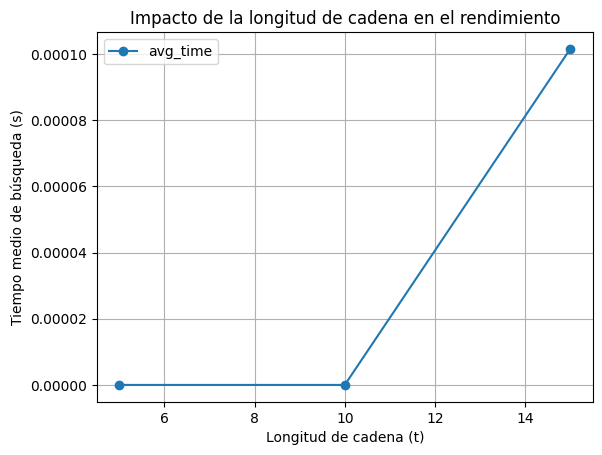

In [59]:
# Parámetros del experimento
dataset = []
charset = '01'; pwd_length = 3
for chain_len in [5, 10, 15]:
    table = generate_table(chain_len, charset, pwd_length)
    timings = []
    # Tomamos 5 hashes de ejemplo
    hashes = [md5_hash(''.join(p)) for p in product(charset, repeat=pwd_length)][:5]
    for h in hashes:
        start_time = time.time()
        search_hash(h, table, chain_len, charset, pwd_length)
        timings.append(time.time() - start_time)
    dataset.append({'long_chain': chain_len, 'avg_time': sum(timings)/len(timings)})

# Presentar resultados
df = pd.DataFrame(dataset)
print(df)

# Graficar impacto de t en el tiempo de búsqueda
df.plot(x='long_chain', y='avg_time', marker='o')
plt.xlabel('Longitud de cadena (t)')
plt.ylabel('Tiempo medio de búsqueda (s)')
plt.title('Impacto de la longitud de cadena en el rendimiento')
plt.grid(True)
plt.show()

- **Interpretación**: a mayor t, más pasos de reducción→hash en búsqueda, mayor tiempo.


## 4. Ejemplo práctico

Demostración completa en un espacio muy reducido para visualizar cada paso.

In [60]:
# Parámetros del ejemplo
charset = 'abc'
pwd_length = 2
chain_length = 4

# 1) Generar la rainbow table
print("Generando rainbow table para charset=", charset, ", pwd_length=", pwd_length, ", chain_length=", chain_length)
table = generate_table(chain_length, charset, pwd_length)
print("\nTabla generada (endpoint → startpoint):")
for end, start in table.items():
    print(f"  {end} → {start}")

# 2) Calcular hash de contraseña secreta
secret = 'ba'
h = md5_hash(secret)
print(f"\nHash MD5 de la contraseña de ejemplo ('{secret}'):", h)

# 3) Recuperar contraseña a partir del hash
recovered = search_hash(h, table, chain_length, charset, pwd_length)
print(f"\nContraseña recuperada: {recovered}")

Generando rainbow table para charset= abc , pwd_length= 2 , chain_length= 4

Tabla generada (endpoint → startpoint):
  cc → cc
  aa → bc

Hash MD5 de la contraseña de ejemplo ('ba'): 07159c47ee1b19ae4fb9c40d480856c4

Contraseña recuperada: ba


- **Paso a paso**:
  1. Listamos endpoints y startpoints.
  2. Calculamos hash de la contraseña secreta.
  3. Ejecutamos búsqueda y mostramos resultado.

## 5. Análisis Crítico y Propuestas de Mejora

1. **Cuantificación de colisiones**:
   - Usando el espacio de contraseñas $A^L$ y la aproximación de colisiones $m(m-1)/(2N)$, para charset de 64 caracteres y longitud 8, $N = 64^8 \approx 2^{48}$. Con 10^6 cadenas, se espera $~0.5$ colisiones.

2. **Tasas de éxito comparadas**:
   - Hellman clásico vs Rainbow tables: las rainbow usan múltiples colores (funciones de reducción) reduciendo las fusiones de cadenas y aumentando el éxito de ~60% a ~75% en tablas estándares [4].

3. **Mitigación mediante salting**:
   - Aplicar salt único por contraseña obliga a recalcular tablas por cada salt, inutilizando las rainbow tables genéricas.
   - Ejemplo: SHA‑1 con salt 64‑bit incrementa $N$ en un factor de $2^{64}$.

4. **Ampliación de espacio**:
   - Incrementar pwd_length o charset (incluir mayúsculas, símbolos) hace que $N$ crezca exponencialmente, reduciendo factibilidad de precomputación.

5. **Propuestas de mejora**:
   - Uso de GPU/FPGA para generación y búsqueda paralela.
   - Tablas dinámicas con esquemas adaptativos de reducción (funciones paramétricas por posición).
   - Integrar mecanismos de rainbow chains invertidas para reducir búsquedas erróneas.

**Referencias**
1. R. Merkle y I. Damgård, "Formal Properties of Cryptographic Hash Functions", 1989.  
2. X. Wang et al., "Collisions for MD5", Crypto 2004.  
3. M. Hellman, "A cryptanalytic time–memory trade-off", IEEE Trans. Inf. Theory, 1980.  
4. P. Oechslin, "Making a faster cryptanalytic time–memory trade-off", CRYPTO 2003.